# Getting the data

In [17]:
from nltk.corpus import gutenberg

fileids = gutenberg.fileids()
print(fileids)

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


### Filtering

In [18]:
boring = {'bible-kjv.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt'} 
fileids = [f for f in fileids if f not in boring] 
texts = [gutenberg.raw(f) for f in fileids]
titles = [f[:-4] for f in fileids]
print(titles)

['austen-emma', 'austen-persuasion', 'austen-sense', 'blake-poems', 'bryant-stories', 'burgess-busterbrown', 'carroll-alice', 'chesterton-ball', 'chesterton-brown', 'chesterton-thursday', 'milton-paradise', 'shakespeare-caesar', 'shakespeare-hamlet', 'shakespeare-macbeth', 'whitman-leaves']


### Preprocessing

In [19]:
substitution = {'Macb.': 'Macbeth',
                'Ham.': 'Hamlet',
                'Qu.': 'Queene',
                'Bru.': 'Brutus',
                'Macd.': 'Macduff',
                ' Mrs ': '',
                ' Mrs.': '',
                'Cassi.': 'Cassius',
                'Hor.': 'Horatio',
                'Laer.': 'Laertes',
                'th\'': ''}

def replace(text, dictionary):
    for k, v in dictionary.items():
        text = text.replace(k, v)
    return text

texts = [replace(text, substitution) for text in texts]

# Building tf-idf vectors

### TfidfVectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(max_df=.5, min_df=1, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(texts)

### Terms

In [21]:
terms = vectorizer.get_feature_names()
a = [t for t in terms if t.startswith('a')][:5]
z = [t for t in terms if t.startswith('z')][-5:]

print(f"{' '.join(a)}\n{' '.join(z)}")

aaron aback abandon abandoned abandoning
zoological zophiel zso zumpt zuyder


### Top terms by tf-idf

In [22]:
top = (-tfidf_matrix).toarray().argsort()[:, :5]
for index, title in enumerate(titles):
    top_terms = [terms[t] for t in top[index]]
    print("{}: {}".format(title, ' '.join(top_terms)))

austen-emma: emma harriet weston knightley elton
austen-persuasion: anne elliot wentworth captain charles
austen-sense: elinor marianne dashwood jennings willoughby
blake-poems: weep thel infant lamb lyca
bryant-stories: jackal margery nightingale big brahmin
burgess-busterbrown: buster joe farmer blacky sammy
carroll-alice: alice gryphon turtle hatter duchess
chesterton-ball: turnbull macian evan police gutenberg
chesterton-brown: flambeau muscari boulnois fanshaw duke
chesterton-thursday: syme professor gregory marquis bull
milton-paradise: hath adam eve satan spake
shakespeare-caesar: brutus cassius caesar haue antony
shakespeare-hamlet: hamlet haue horatio queene laertes
shakespeare-macbeth: macbeth haue macduff rosse vpon
whitman-leaves: states poems cities america chant


# Clustering and dimensionality reduction

### k-means

In [23]:
from sklearn.cluster import KMeans
from collections import defaultdict

kmeans = KMeans(n_clusters=5, n_init=50)
labels = kmeans.fit_predict(tfidf_matrix)

clustering = defaultdict(list)
for title, label in zip(titles, labels):
    clustering[label].append(title)
    
for cluster, elements in sorted(clustering.items()):
    elements = ', '.join(elements)
    print(f'{cluster}: {elements}')
    
print(kmeans.inertia_)

0: bryant-stories, burgess-busterbrown, carroll-alice
1: chesterton-ball, chesterton-brown, chesterton-thursday
2: blake-poems, milton-paradise, whitman-leaves
3: austen-emma, austen-persuasion, austen-sense
4: shakespeare-caesar, shakespeare-hamlet, shakespeare-macbeth
8.985937270983072


### PCA & t-SNE

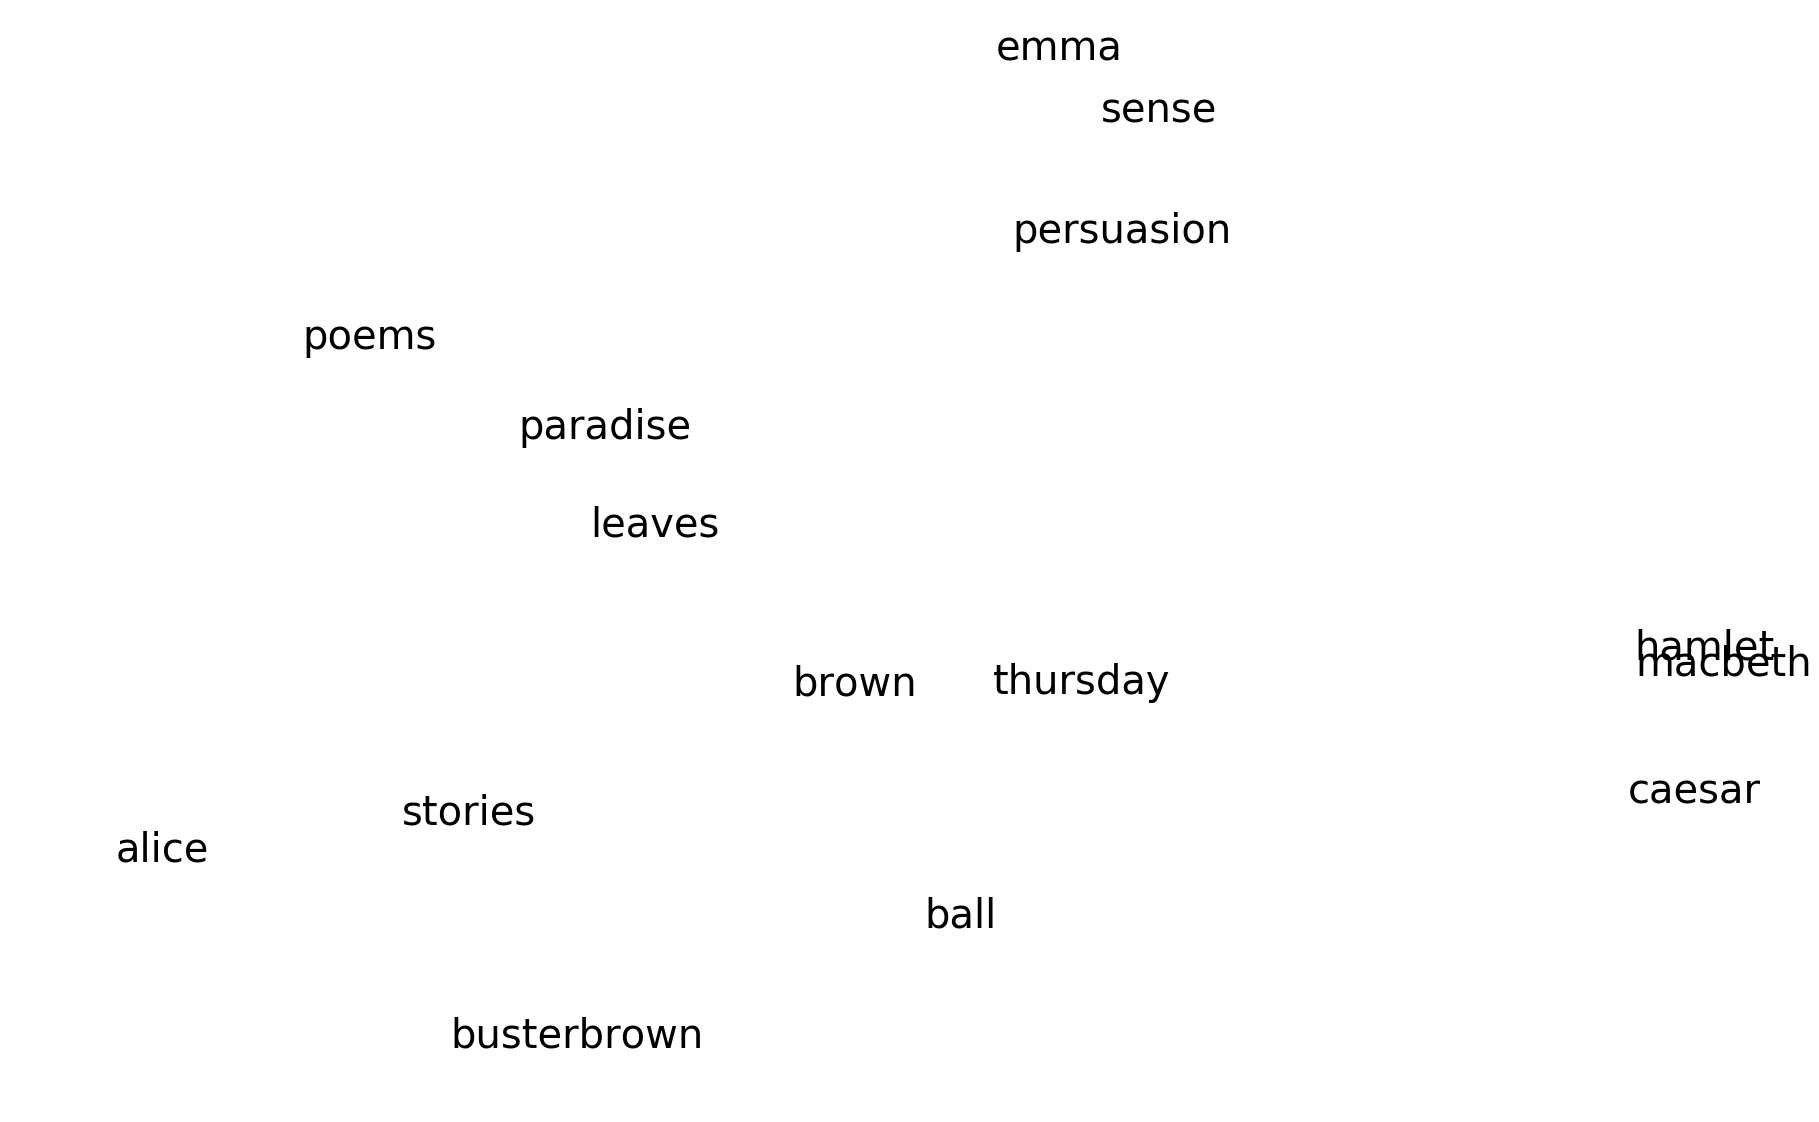

In [27]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import re

tsne = TSNE(n_components=2,
            random_state=0,
            learning_rate=10,
            perplexity=10,
            n_iter = 5000)
dense_tfidf_matrix = tfidf_matrix.todense()
points_tsne = tsne.fit_transform(dense_tfidf_matrix)

sklearn_pca = PCA(n_components=2)
points_pca = sklearn_pca.fit_transform(dense_tfidf_matrix)

#visualization
plt.style.use('ggplot')
x, y = points_tsne[:, 0], points_tsne[:, 1]

fig, ax = plt.subplots(figsize=(30, 20))
ax.scatter(x, y, alpha=0)
plt.axis('off')
ax.set_facecolor("red")

for i, title in enumerate(titles):
    if title == '-macbeth':
        ax.annotate(title.split('-')[1], (x[i],y[i]+0.1), fontsize=40)
    else:
        ax.annotate(title.split('-')[1], (x[i],y[i]), fontsize=40)